In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


FEATURE ENGINEERING AND FEATURE SELECTION USING SUITABLE METHOD

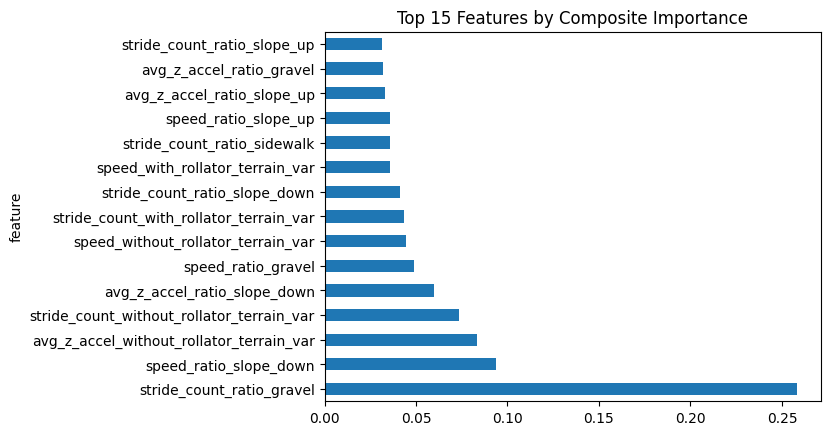

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/new gait data/Final Data/gait_data_final.csv")


# ------------------- STEP 1: DATA SPLITTING -------------------
# Split data FIRST before any processing
X = df.copy()
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)


# ------------------- STEP 2: SAFE LABEL CREATION -------------------
def create_labels(df, train_stats=None):
    """Create labels using proper data isolation"""
    df = df.copy()

    if train_stats is None:  # Training data mode
        # Calculate medians for missing values
        gravel_medians = {
            "with_rollator": df["stride_count_with_rollator_gravel"].median(),
            "without_rollator": df["stride_count_without_rollator_gravel"].median(),
        }

        # Calculate ratio using training data
        with_rollator = df["stride_count_with_rollator_gravel"].fillna(
            gravel_medians["with_rollator"]
        )
        without_rollator = df["stride_count_without_rollator_gravel"].fillna(
            gravel_medians["without_rollator"]
        )
        temp_ratio = with_rollator / without_rollator.replace(0, np.nan)

        # Store thresholds for test data
        thresholds = {
            "q25": temp_ratio.quantile(0.25),
            "q75": temp_ratio.quantile(0.75),
        }

        df["label"] = (
            (temp_ratio > thresholds["q75"]) | (temp_ratio < thresholds["q25"])
        ).astype(int)
        return df, gravel_medians, thresholds

    else:  # Test data mode
        with_rollator = df["stride_count_with_rollator_gravel"].fillna(
            train_stats["with_rollator"]
        )
        without_rollator = df["stride_count_without_rollator_gravel"].fillna(
            train_stats["without_rollator"]
        )
        temp_ratio = with_rollator / without_rollator.replace(0, np.nan)

        df["label"] = (
            (temp_ratio > train_stats["q75"]) | (temp_ratio < train_stats["q25"])
        ).astype(int)
        return df


# Create labels properly isolated
train_df, gravel_medians, thresholds = create_labels(X_train)
test_df = create_labels(
    X_test,
    train_stats={
        "with_rollator": gravel_medians["with_rollator"],
        "without_rollator": gravel_medians["without_rollator"],
        "q25": thresholds["q25"],
        "q75": thresholds["q75"],
    },
)


# ------------------- STEP 3: OPTIMIZED FEATURE ENGINEERING -------------------
def engineer_features(df):
    """Batch feature engineering to avoid fragmentation"""
    # Base features
    base_features = df.copy()
    engineered = pd.DataFrame(index=df.index)

    # Metric collections
    ratio_features = []
    diff_features = []
    terrain_features = []

    # 1. Ratio & Difference Features
    for metric in ["stride_count", "speed", "avg_z_accel"]:
        for terrain in ["slope_up", "slope_down", "gravel", "sidewalk"]:
            with_col = f"{metric}_with_rollator_{terrain}"
            without_col = f"{metric}_without_rollator_{terrain}"

            if with_col in df.columns and without_col in df.columns:
                # Ratio
                ratio_name = f"{metric}_ratio_{terrain}"
                denom = (
                    df[without_col].replace(0, np.nan).fillna(df[without_col].median())
                )
                engineered[ratio_name] = df[with_col] / denom
                ratio_features.append(ratio_name)

                # Difference
                diff_name = f"{metric}_diff_{terrain}"
                engineered[diff_name] = df[with_col] - df[without_col]
                diff_features.append(diff_name)

    # 2. Terrain Variation Features
    for condition in ["with_rollator", "without_rollator"]:
        for metric in ["stride_count", "speed", "avg_z_accel"]:
            terrain_cols = [
                f"{metric}_{condition}_{terrain}"
                for terrain in ["slope_up", "slope_down", "gravel", "sidewalk"]
            ]
            if all(col in df.columns for col in terrain_cols):
                # Variance
                var_name = f"{metric}_{condition}_terrain_var"
                engineered[var_name] = df[terrain_cols].var(axis=1)

                # Range
                range_name = f"{metric}_{condition}_terrain_range"
                engineered[range_name] = df[terrain_cols].max(axis=1) - df[
                    terrain_cols
                ].min(axis=1)

                terrain_features.extend([var_name, range_name])

    # Combine all features
    full_df = pd.concat([base_features, engineered], axis=1)
    return full_df, ratio_features + diff_features + terrain_features


# Apply engineering
train_engineered, feature_names = engineer_features(train_df)
test_engineered, _ = engineer_features(test_df)

# ------------------- STEP 4: IMPROVED FEATURE SELECTION -------------------
# Remove only truly redundant features (correlation > 0.95)
corr_matrix = train_engineered[feature_names].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
filtered_features = [f for f in feature_names if f not in high_corr]

# Final feature selection using composite importance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_engineered[filtered_features])
X_test_scaled = scaler.transform(test_engineered[filtered_features])

# Ensemble feature importance
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, train_engineered["label"])

# Select top features from multiple methods
importance_df = pd.DataFrame(
    {
        "feature": filtered_features,
        "importance": rf.feature_importances_,
        "perm_importance": permutation_importance(
            rf, X_train_scaled, train_engineered["label"], n_repeats=10, random_state=42
        ).importances_mean,
    }
)

# Combine scores
importance_df["composite_score"] = (
    importance_df["importance"] + importance_df["perm_importance"]
)

# Select top 20 features
final_features = importance_df.nlargest(20, "composite_score")["feature"].tolist()

# ------------------- STEP 5: SAVE & VISUALIZE -------------------
# ------------------- MODIFIED STEP 5: SAVE & VISUALIZE -------------------
# Save feature names
pd.DataFrame({"feature_names": final_features}).to_csv(
    "selected_feature_names.csv", index=False
)  # ADD THIS LINE

# Save final dataset
final_train = train_engineered[["label"] + final_features]
final_test = test_engineered[["label"] + final_features]
pd.concat([final_train, final_test]).to_csv(
    "gait_features_engineered_v2.csv", index=False
)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(
    pd.concat([final_train, final_test])[final_features].corr(),
    cmap="coolwarm",
    center=0,
)
plt.title("Feature Correlation Matrix")
plt.savefig("feature_correlation_v2.png", bbox_inches="tight")
plt.close()

# Feature importance plot
importance_df.nlargest(15, "composite_score").set_index("feature")[
    "composite_score"
].plot.barh()
plt.title("Top 15 Features by Composite Importance")
plt.savefig("feature_importance_v2.png", bbox_inches="tight")

In [ ]:
# Print Top 15 Features by Composite Importance (Ranked List)
top_features = importance_df.nlargest(15, "composite_score")
top_features = top_features.sort_values(
    by="composite_score", ascending=False
).reset_index(drop=True)

print("Top 15 Features Ranked by Composite Importance:\n")
for idx, row in top_features.iterrows():
    print(f"{idx + 1}. {row['feature']}  (Score: {row['composite_score']:.4f})")

Top 15 Features Ranked by Composite Importance:

1. stride_count_ratio_gravel  (Score: 0.2582)
2. speed_ratio_slope_down  (Score: 0.0935)
3. avg_z_accel_without_rollator_terrain_var  (Score: 0.0833)
4. stride_count_without_rollator_terrain_var  (Score: 0.0734)
5. avg_z_accel_ratio_slope_down  (Score: 0.0599)
6. speed_ratio_gravel  (Score: 0.0492)
7. speed_without_rollator_terrain_var  (Score: 0.0447)
8. stride_count_with_rollator_terrain_var  (Score: 0.0436)
9. stride_count_ratio_slope_down  (Score: 0.0413)
10. speed_with_rollator_terrain_var  (Score: 0.0360)
11. stride_count_ratio_sidewalk  (Score: 0.0356)
12. speed_ratio_slope_up  (Score: 0.0356)
13. avg_z_accel_ratio_slope_up  (Score: 0.0331)
14. avg_z_accel_ratio_gravel  (Score: 0.0317)
15. stride_count_ratio_slope_up  (Score: 0.0316)


In [ ]:
# -------------------- COMPLETE MODEL TRAINING CODE WITH METRICS -------------------
import pandas as pd
import numpy as np
import time
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
    balanced_accuracy_score,
    matthews_corrcoef,
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

warnings.filterwarnings("ignore")

# -------------------- Configuration --------------------
RANDOM_STATE = 42
TEST_SIZE = 0.3
N_JOBS = -1

# -------------------- Data Preparation --------------------
print("Starting gait abnormality detection...")

try:
    df = pd.read_csv("gait_features_engineered_v2.csv")
    selected_features = pd.read_csv("selected_feature_names.csv")[
        "feature_names"
    ].tolist()
except FileNotFoundError as e:
    raise RuntimeError("Run feature engineering code first!") from e

X = df[selected_features]
y = df["label"].astype(int)

# Clean and split data
X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# -------------------- Model Training & Evaluation --------------------
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Train and evaluate model with timing metrics"""
    metrics = {}

    # Training
    start_train = time.perf_counter()
    model.fit(X_train, y_train)
    metrics["train_time"] = time.perf_counter() - start_train

    # Inference
    start_infer = time.perf_counter()
    y_pred = model.predict(X_test)
    metrics["infer_time"] = (
        (time.perf_counter() - start_infer) / len(X_test) * 1000
    )  # ms/sample

    # Calculate metrics
    metrics.update(
        {
            "f1": f1_score(y_test, y_pred),
            "bal_acc": balanced_accuracy_score(y_test, y_pred),
            "mcc": matthews_corrcoef(y_test, y_pred),
            "auc": None,
        }
    )

    # Calculate AUC if possible
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        metrics["auc"] = auc(fpr, tpr)

    return metrics, y_pred


# Initialize models
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100, class_weight="balanced", random_state=RANDOM_STATE
    ),
    "Support Vector Machine": SVC(
        probability=True, class_weight="balanced", random_state=RANDOM_STATE
    ),
    "Gradient Boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
}

# Train and evaluate all models
print("\n=== Training Baseline Models ===")
performance_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    metrics, y_pred = evaluate_model(
        model, X_train_scaled, y_train, X_test_scaled, y_test
    )

    # Store results
    performance_results[name] = metrics

    # Print results
    if metrics["auc"] is not None:
        print(f"AUC: {metrics['auc']:.4f}")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Abnormal"]))
    print(f"Training Time: {metrics['train_time']:.2f}s")
    print(f"Inference Speed: {metrics['infer_time']:.2f}ms/sample")
    print(f"Balanced Accuracy: {metrics['bal_acc']:.4f}")
    print(f"MCC: {metrics['mcc']:.4f}")

# -------------------- Model Selection --------------------
best_model_name = max(performance_results, key=lambda k: performance_results[k]["f1"])
best_metrics = performance_results[best_model_name]

print("\n=== Best Model ===")
print(f"Model: {best_model_name}")
print(f"F1 Score: {best_metrics['f1']:.4f}")
print(f"Balanced Accuracy: {best_metrics['bal_acc']:.4f}")
print(f"MCC: {best_metrics['mcc']:.4f}")
print(f"AUC: {best_metrics['auc'] if best_metrics['auc'] else 'N/A':.4f}")
print(f"Training Time: {best_metrics['train_time']:.2f}s")
print(f"Inference Speed: {best_metrics['infer_time']:.2f}ms/sample")

# -------------------- Hyperparameter Tuning --------------------
print(f"\n=== Tuning {best_model_name} ===")

param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l2", None],
        "solver": ["lbfgs", "newton-cg"],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
    },
    "Support Vector Machine": {
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "kernel": ["rbf", "linear"],
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5],
    },
}

grid_search = GridSearchCV(
    models[best_model_name],
    param_grids[best_model_name],
    cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE),
    scoring="f1",
    n_jobs=N_JOBS,
)

print("Performing grid search...")
start_tune = time.perf_counter()
grid_search.fit(X_train_scaled, y_train)
tune_time = time.perf_counter() - start_tune

best_model = grid_search.best_estimator_
tune_metrics, y_pred_tuned = evaluate_model(
    best_model, X_train_scaled, y_train, X_test_scaled, y_test
)

print("\n=== Tuned Model Performance ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"CV F1 Score: {grid_search.best_score_:.4f}")
print(f"Test F1 Score: {tune_metrics['f1']:.4f}")
print(f"Training Time: {tune_time:.2f}s + {tune_metrics['train_time']:.2f}s")
print(f"Inference Speed: {tune_metrics['infer_time']:.2f}ms/sample")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=["Normal", "Abnormal"]))

# -------------------- Save Final Model --------------------
joblib.dump(
    {
        "model": best_model,
        "scaler": scaler,
        "features": selected_features,
        "metrics": tune_metrics,
    },
    "gait_abnormality_model.pkl",
)

print("\nPipeline completed. Model saved to gait_abnormality_model.pkl")

Starting gait abnormality detection...

=== Training Baseline Models ===

Training Logistic Regression...
AUC: 0.5875
              precision    recall  f1-score   support

      Normal       0.50      0.38      0.43         8
    Abnormal       0.58      0.70      0.64        10

    accuracy                           0.56        18
   macro avg       0.54      0.54      0.53        18
weighted avg       0.55      0.56      0.54        18

Training Time: 0.02s
Inference Speed: 0.03ms/sample
Balanced Accuracy: 0.5375
MCC: 0.0791

Training Random Forest...
AUC: 0.7812
              precision    recall  f1-score   support

      Normal       0.67      0.75      0.71         8
    Abnormal       0.78      0.70      0.74        10

    accuracy                           0.72        18
   macro avg       0.72      0.72      0.72        18
weighted avg       0.73      0.72      0.72        18

Training Time: 0.23s
Inference Speed: 0.55ms/sample
Balanced Accuracy: 0.7250
MCC: 0.4472

Training

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming you have features `X` and target `y`
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Standardizing the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now, apply PCA only to X_test_scaled, which has the same number of samples as y_test
X_pca = PCA(n_components=2).fit_transform(X_test_scaled)

# Check the shapes again
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_pca:", X_pca.shape)

# Ensure that the length of y_test and X_pca are the same
assert len(X_pca) == len(
    y_test
), f"Mismatch in number of samples: {len(X_pca)} vs {len(y_test)}"

Shape of X_test_scaled: (18, 18)
Shape of y_test: (18,)
Shape of X_pca: (18, 2)


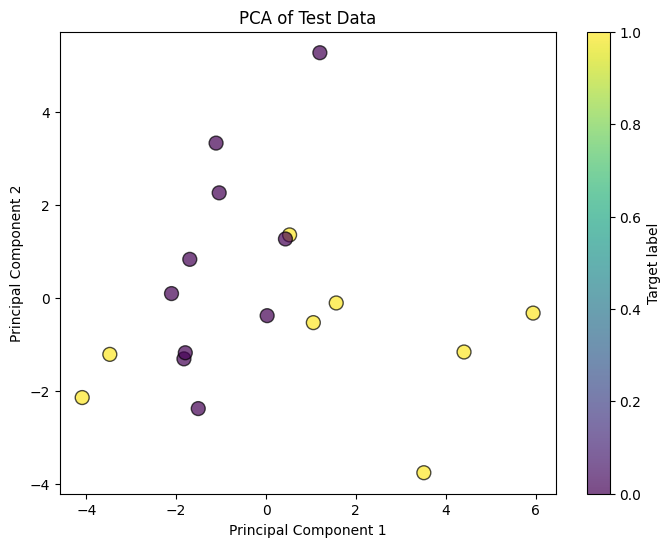

In [ ]:
import matplotlib.pyplot as plt

# Assuming your target labels are binary or categorical, you can use different colors for each class
plt.figure(figsize=(8, 6))

# Plot PCA
plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=y_test, cmap="viridis", edgecolor="k", s=100, alpha=0.7
)

plt.title("PCA of Test Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Target label")

plt.show()